# 1. Hodgkin-Huxley Dynamics 

In this section, we will be working with the neuronal dynamics of the Hodgkin-Huxley (HH) model.

## 1.1 Setting up the model (15 pts)

### 1.1.1 Parameter values (1 pt)

To start, we are going to define some global variables that will hold the parameter values defined on Slide 29 of Lecture 6.  

Note - the values listed on this slide are for an area of .1 mm$^2$, but the equations use conductances over 1 cm$^2$, be sure to convert correctly.  Use μS for conductance, mV for voltage, and pF for capacitance. 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

g_Leak = 0.3
g_Na = 120
g_K = 36
v_Na = 45
v_K = -82
v_Leak = -60
C_m  = 1

If you did it right, the sum of all constants should be ~60.3:

In [24]:
print(g_Leak + g_Na + g_K + v_Na + v_K + v_Leak + C_m)

60.30000000000001


### 1.1.2 Gating variables (6 pts)

Next, we will be defining our gating variables.  Set up equations for the various activation and deactivations (Equations 5.22 and 5.24):

In [33]:
# Gating variables
def alpha_m(Vm):
    return (0.1*(Vm+40)) / (1-np.exp(-0.1*(Vm+40)))

def beta_m(Vm):
    return 4*np.exp((-0.0556*(Vm+65)))

def alpha_h(Vm):
  return 0.07*np.exp(-0.05*(Vm+65))

def beta_h(Vm):
    return 1/(1+np.exp(-0.1*(Vm+35)))

def alpha_n(Vm):
    return (0.01*(Vm+55)) / (1-np.exp(-0.1*(Vm+55)))

def beta_n(Vm):
    return 0.125*np.exp(-0.0125*(Vm+65))

If set up correctly, you should be able to produce the plots on Slide 31 of Lecture 6: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


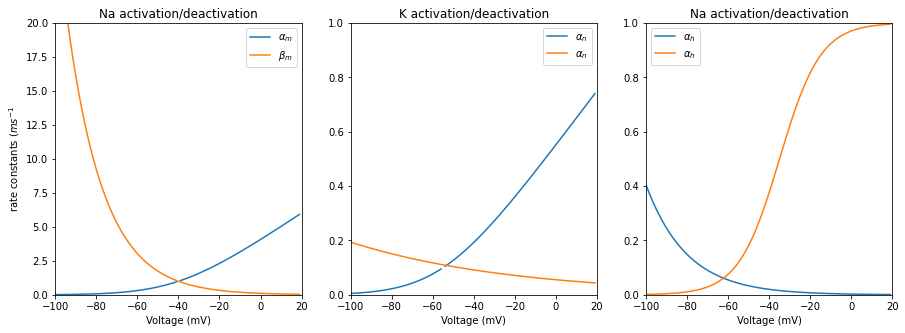

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

Vm = np.arange(-100, 20, 1)

axes[0].plot(Vm, alpha_m(Vm), label='$\\alpha_m$')
axes[0].plot(Vm, beta_m(Vm), label='$\\beta_m$')
axes[0].set_xlim(-100, 20)
axes[0].set_ylim(0, 20)
axes[0].set_xlabel('Voltage (mV)')
axes[0].set_ylabel('rate constants ($m s^{-1}$')
axes[0].set_title('Na activation/deactivation')
axes[0].legend()

axes[1].plot(Vm, alpha_n(Vm), label='$\\alpha_n$')
axes[1].plot(Vm, beta_n(Vm), label='$\\alpha_n$')
axes[1].set_xlim(-100, 20)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('Voltage (mV)')
axes[1].set_title('K activation/deactivation')
axes[1].legend()

axes[2].plot(Vm, alpha_h(Vm), label='$\\alpha_h$')
axes[2].plot(Vm, beta_h(Vm), label='$\\alpha_h$')
axes[2].set_xlim(-100, 20)
axes[2].set_ylim(0, 1)
axes[2].set_xlabel('Voltage (mV)')
axes[2].set_title('Na activation/deactivation')
axes[2].legend()


### 1.1.3 Ionic currents (3 pts)

Next, we will need to set up our ODEs.  To start, let's break our model into its separate components (Na, K, and Leak)

Recall that:

$C \frac{dV}{dt} = I - I_K - I_{Na} - I_L$

$C \frac{dV}{dt} = I - \bar{g}_K n^4 (V - E_K) - m^3 h \bar{g}_{Na} (V - E_{Na}) - g_L (V - E_L)$


So as a first step, we need to set up all the ionic currents:

In [7]:
def I_K(Vm, n):
  return g_K*(n**4)*(Vm-v_K)
  
def I_Na(Vm, m, h):
  return (m**3)*h*g_Na*(Vm-v_Na)

def I_Leak(Vm):
  return g_Leak*(Vm-v_Leak)

### 1.1.4 ODEs (4 pts)

With the equations above, we should be able to define our differential equations. Let's define them in a way that we can use scipy to integrate over the derivatives. Here's an example: 

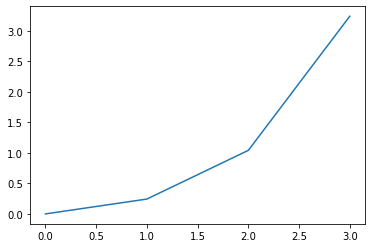

In [8]:
#Sample code from https://stackoverflow.com/questions/32004697/current-iteration-in-scipy-odeint

import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d

t_arr = np.array([0,1,2,3])
z_arr = np.array([0.1, 0.2, 0.25, 0.22])
finterp = interp1d(t_arr,z_arr,fill_value='extrapolate') #create interpolation function

def func(y,t,z):
    zt = finterp(t) # call interpolation at time t
    return y+zt

result = odeint(func, [0], t_arr, (z_arr,))
plt.plot(result)

Following the above template, let's define our set of derivative equations using the interpolated electrical current over all time points.

Recall that:



In [20]:
def C_dvdt(C, t, I_interp):
  Vm, m, n, h = C
  I_instantaneous = I_interp(t) # Use to access the electrical current at the current time

  dVdt = (I_instantaneous - I_K(Vm,n) - I_Na(Vm,m,h) - I_Leak(Vm))/C_m
  dndt = alpha_n(Vm) * (1-n) - beta_n(Vm) * n
  dmdt = alpha_m(Vm) * (1-m) - beta_m(Vm) * m
  dhdt = alpha_h(Vm) * (1-h) - beta_h(Vm) * h

  return [dVdt, dmdt, dndt,  dhdt]

### 1.1.5 Injecting current (1 pt)

Finally, let's create a time array going from 0 to 300, incrementing by 1.  Next, create a stimulus that is 10μA for (50 < t < 100) and 30μA for (150 < t < 200). Make sure to label your axes.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'Current')

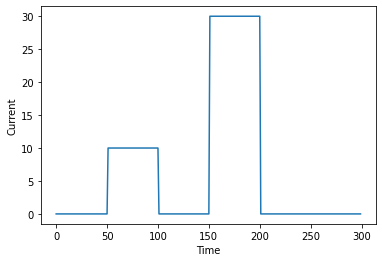

In [18]:
t = np.array(range(300))
I_input = np.zeros_like(t)
I_input[t > 50] = 10
I_input[t > 100] = 0
I_input[t > 150] = 30
I_input[t > 200] = 0

plt.plot(t,I_input)
plt.xlabel('Time')
plt.ylabel('Current')

## 1.2 Running the model

Now we should have all the pieces together to simulate an action potential!

The following code should not require any modifications to run:

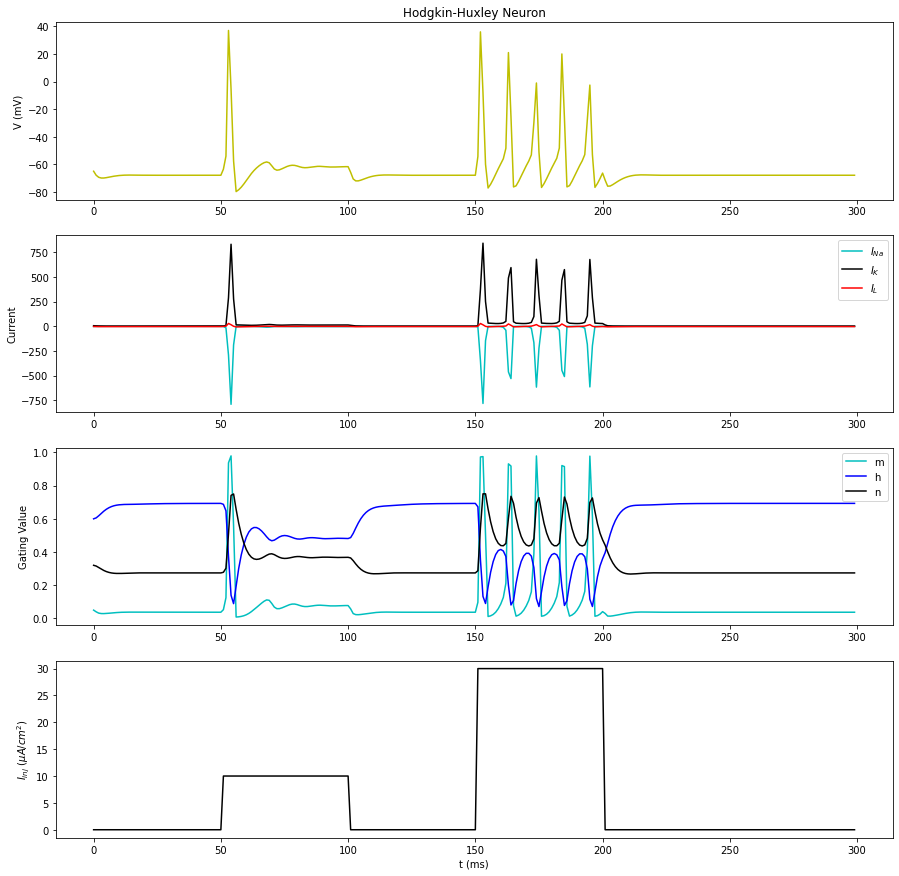

In [35]:
starting_vals = [-65.0, 0.05, 0.32, 0.6 ]
I_interp = interp1d(t, I_input, fill_value='extrapolate') #create interpolation function

C = odeint(C_dvdt, starting_vals, t, (I_interp,))

V = C[:,0]
m = C[:,1]
n = C[:,2]
h = C[:,3]

ina = I_Na(V, m, h)
ik = I_K(V,n)
il = I_Leak(V)


fig, axes = plt.subplots(4, 1, figsize = (15,15))

axes[0].plot(t, V, 'y')
axes[0].set_title('Hodgkin-Huxley Neuron')
axes[0].set_ylabel('V (mV)')

axes[1].plot(t, ina, 'c', label='$I_{Na}$')
axes[1].plot(t, ik, 'k', label='$I_{K}$')
axes[1].plot(t, il, 'r', label='$I_{L}$')
axes[1].set_ylabel('Current')
axes[1].legend()

axes[2].plot(t, m, 'c', label='m')
axes[2].plot(t, h, 'b', label='h')
axes[2].plot(t, n, 'k', label='n')
axes[2].set_ylabel('Gating Value')
axes[2].legend()

i_inj_values = [I_input[_t] for _t in t]
axes[3].plot(t, i_inj_values, 'k')
axes[3].set_xlabel('t (ms)')
axes[3].set_ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')

plt.show()

## 1.3 Analyzing the model (5 pts)

Explain the above plots with respect to:

1) What is happening to the sodium channel (in both pulses)

2) What is happening to the potassium channel (in both pulses)

3) How does this lead to an action potential(s)?

---

First off, m, h, and n are gating variables that represent how permissive an ion channel is to a particular ion. Each gating variable describes an oppening and a closing process. We also know that in part 1.1.4, alpha is the opening rate as a function of V, and beta is the closing rate as a function of V. The m and n are activation variables and h is inactivation.

Moreover, we know in Gating values, <b>m is the proportion of activating Na+ molecules on the inside</b> and <b> h is the proportion of inactivating Na+ molecules on the outside</b>. Plus, n is representing a dimensionless parameter that can vary between 0 and 1 about the K+ permisability. 

In a lower current (e.i. 10 microA), we can see that activating Na+ molecules on the inside (light blue) is getting increased, while the proportion of inactivating Na+ molecules on the outside getting decreased. Also, K+ channels are getting opened up. So, the gating value for K+ <b>(n)</b> and activating Na+ <b>(m)</b> are getting increased (channels are open), while the proportion of inactivating Na+ <b>(h)</b> is getting decreased.

As a result of that, we can see that the current flow of K+ is getting more positive (since we are comparing K+ on the outside of the cell with the inside, and K+ is moving towards the outside), and the current of the Na+ is getting more negative (we would have less Na+ outside the cell). Also, we can see that the Leak is pretty much steady regardless of whether we have an action potential or not.

So, we get to the point where we are experiencing an action potential (seeing the potential of the cell rises after arround 50mS). However, the current is not high enough to help activating Na+ molecules on the inside overcome the proportion of inactivating Na+ molecules on the outside. So, the cell remains in the resting potential after one spike. On the other hand, when we increase the current, although m and n will remain relatively in the same shape, the current will help to maintain the inactivating Na+ portion in low volume. Hence, more Na+ molecules will travel to the inside of the cell everytime, and we will experience one spike after another (as it is obvious in the top voltage plot).

And finally, again, it is obvious from the Current vs. Time plot that we have multiple times that K+ gets outside the cell and Na+ moves inside.

---